In [539]:
import sys
import os
sys.path.insert(0, os.path.join(os.pardir, 'sparat'))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fmin
import seaborn as sns
import statsmodels.api as sm

from data_processing.rat import load_rat_items
from data_processing.generate_association_matrix import load_assoc_mat
from data_processing.spgen import load_pointers
from model.stimulus import filter_valid
from data_processing.spgen import load_pointers

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## Load experimental data

In [4]:
basedir = os.pardir
path_file = os.path.join(basedir, 'data', 'raw', '144CompoundBowden.xlsx')
xls = pd.ExcelFile(path_file)

Load the excel sheet with values from the paper and sort RAT problems according to the t=2 condition:

In [5]:
df = xls.parse('RAT stimuli part1.csv', skip_footer=2)
df.columns = [
    'items', 'solution', '2s-%',
    '7s-%',  '7s-t-mean', '7s-t-sd',
    '15s-%', '15s-t-mean', '15s-t-sd',
    '30s-%', '30s-t-mean', '30s-t-sd']
df = df.sort_values('2s-%', ascending=False)
df = df.set_index(np.arange(len(df)))

## Load association data

In [6]:
def pointers2assoc(pointers, i2w, w2i):
    return np.dot(pointers, pointers.T), i2w, w2i

In [7]:
datasets = {
        k: load_assoc_mat(os.path.join(basedir, 'data', 'associationmatrices'), k)
        for k in ['freeassoc_asymmetric', 'freeassoc_symmetric', 'google_symmetric']
    }

In [12]:
datasets.update({
        k: pointers2assoc(*load_pointers(os.path.join(basedir, 'data', 'semanticpointers'), k))
        for k in [
            'freeassoc_symmetric_svd_factorize_5018w_512d',
            'google_symmetric_svd_factorize_5018w_768d'
        ]
    })

In [13]:
pointers, i2w, w2i = load_pointers(
    os.path.join(basedir, 'data', 'semanticpointers'),
    'freeassoc_asymmetric_randomize_orthonormal_5018w_5120d')
assoc = datasets['freeassoc_asymmetric'][0]
pointers_sq = np.dot(pointers, pointers.T)
datasets['neural'] = (np.dot(pointers_sq, np.dot(assoc, pointers_sq)), i2w, w2i)

IOError: [Errno 2] No such file or directory: '../data/semanticpointers/freeassoc_asymmetric_randomize_orthonormal_5018w_5120d.npy'

In [14]:
def solve_p(row, assoc, i2w, w2i, ws=(1., 1., 1.)):
    '''
    Compute probabilities for each row based on associations and store the result in col_title.
    '''
    assert len(ws) == 3
    beta = ws[-1]
    alphas = (1., ws[0], ws[1])
    
    cues = row['items'].upper().split('/')
    target = row['solution'].upper()
    
    if not all(w in i2w for w in cues+[target]):
        return np.nan
    else:
        strengths = np.sum([alphas[i]*assoc[w2i[cue], :] for i, cue in enumerate(cues)], axis=0)
        for cue in cues:
            strengths[w2i[cue]] = 0.
        normed = strengths / np.sum(strengths)
        return beta * 100 * normed[w2i[target]]

In [15]:
def model(params, assoc, i2w, w2i):
    x = df.apply(solve_p, args=(assoc, i2w, w2i, params), axis=1).dropna()
    y = df.loc[x.index]
    return np.sqrt(np.sum(np.square(x - y['2s-%'])))

In [16]:
fits = {
        k: fmin(model, (1., 1., 1.), assoc)
        for k, assoc in datasets.items()
    }

Optimization terminated successfully.
         Current function value: 80.122523
         Iterations: 129
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 103.012847
         Iterations: 127
         Function evaluations: 227
Optimization terminated successfully.
         Current function value: 109.330405
         Iterations: 122
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 79.912015
         Iterations: 74
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 82.733698
         Iterations: 89
         Function evaluations: 164


In [17]:
fits

{'freeassoc_asymmetric': array([ 2.05991529,  1.19931146,  1.13050399]),
 'freeassoc_symmetric': array([ 2.49525947,  1.63290787,  2.85911463]),
 'freeassoc_symmetric_svd_factorize_5018w_512d': array([ 3.22113594,  1.656956  ,  7.39585901]),
 'google_symmetric': array([ 10.88602999,   1.75742063,   4.21290374]),
 'google_symmetric_svd_factorize_5018w_768d': array([ 10.98445868,   0.42890124,   8.18461647])}

In [18]:
def model_r(params, assoc, i2w, w2i):
    x = df.apply(solve_p, args=(assoc, i2w, w2i, params), axis=1).dropna()
    y = df.loc[x.index]
    return sm.OLS(x, y['2s-%']).fit().rsquared

r_values = {k: model_r(v, *datasets[k]) for k, v in fits.items()}
r_values

{'freeassoc_asymmetric': 0.58193583237955693,
 'freeassoc_symmetric': 0.57973036097046127,
 'freeassoc_symmetric_svd_factorize_5018w_512d': 0.55189100719134632,
 'google_symmetric': 0.30529318767483782,
 'google_symmetric_svd_factorize_5018w_768d': 0.2174705471979933}

In [19]:
table = r'''
\begin{{tabular}}{{lrrrrr}} \toprule
Association matrix & $\alpha_1$ & $\alpha_2$ & $\alpha_3$ & $\beta$ & $r^2$ \\ \midrule
\fanasym{{}} & 1.0 & {fanasym} \\
\fansym{{}} & 1.0 & {fansym} \\
\ngsym{{}} & 1.0 & {ngsym4096} \\
\ngsym[768] & 1.0 & {ngsym768} \\
\bottomrule
\end{{tabular}}
'''.format(
    fanasym=' & '.join(r"\num{{{:.2f}}}".format(x)  for x in list(fits['freeassoc_asymmetric']) + [r_values['freeassoc_asymmetric']]),
    fansym=' & '.join(r"\num{{{:.2f}}}".format(x) for x in list(fits['freeassoc_symmetric']) + [r_values['freeassoc_symmetric']]),
    ngsym4096=' & '.join(r"\num{{{:.2f}}}".format(x) for x in
        list(fits['google_symmetric']) +
        [r_values['google_symmetric']]),
    ngsym768=' & '.join(r"\num{{{:.2f}}}".format(x) for x in
        list(fits['google_symmetric_svd_factorize_5018w_768d']) + 
        [r_values['google_symmetric_svd_factorize_5018w_768d']]))

In [20]:
with open(os.path.join(basedir, 'txt', 'cogsci-paper', 'tables', 'rvalues.tex'), 'wt') as f:
    f.write(table)

IOError: [Errno 2] No such file or directory: '../txt/cogsci-paper/tables/rvalues.tex'

## Plot

In [21]:
sns.set('paper', 'ticks')

column_width_pt = 243.91125
pt2inch = 1. / 72.27
column_width_inch = pt2inch * column_width_pt

In [22]:
p = df['2s-%'] / 100.
n = 89
z = 1.96
ci = 100 * 1.96 * np.sqrt(p * (1 - p) / float(n))
lci, uci = df['2s-%'] - ci, df['2s-%'] + ci

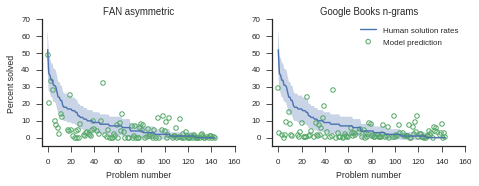

In [347]:
%matplotlib inline
colors = sns.color_palette(n_colors=2)
titles = {
    #'freeassoc_symmetric': "FAN symmetric",
    'freeassoc_asymmetric': "FAN asymmetric",
    'google_symmetric': "Google Books n-grams",
    #'freeassoc_symmetric_svd_factorize_5018w_512d': "FAN symmetric 512d",
    #'google_symmetric_svd_factorize_5018w_4096d': "Google Books n-grams, 4096 dimensions"
}
toplot = ['freeassoc_asymmetric', 'google_symmetric']

fig = plt.figure(figsize=(2 * column_width_inch, 0.8 * column_width_inch))

ax = None
for i, k in enumerate(toplot):
    ax = fig.add_subplot(1, len(toplot), i + 1, sharex=ax)
    ax.plot(df['2s-%'].values, c=colors[0], label='Human solution rates')
    ax.fill_between(np.arange(len(df)), lci, uci, alpha=0.3, color=colors[0])
    ax.scatter(np.arange(len(df)), df.apply(solve_p, args=datasets[k] + (fits[k],), axis=1), 
               linewidths=1, edgecolors=colors[1], c=(1, 1, 1, 0), marker='o',
              label='Model prediction')
    
    ax.set_title(titles[k])
    ax.set_xlabel('Problem number')
    if i <= 0:
        ax.set_ylabel("Percent solved")
    
    ax.set_xlim(left=-5)
    ax.set_ylim(bottom=-5)
    
plt.legend()
sns.despine()
fig.tight_layout()

In [ ]:
fig.savefig(os.path.join(basedir, 'txt', 'cogsci-paper', 'figures', 'fit.pdf'))

## Error analysis

This is a first-approximation of error analysis, since the model is fairly simple and we are not really trying to account for any more things than accuracy matching. Therefore, to see which method is getting problems right/wrong as humans do, we take a set of easier problems and a set of harder problems and see how every method scores for those.

To get the approximately same amount of easy and hard problems they have been devided in following intervals:

easy: >15%

hard: [5,10%]

In [349]:
fa_p = df.apply(solve_p, args=datasets[toplot[0]] + (fits[toplot[0]],), axis=1).values    # norms
gn_p = df.apply(solve_p, args=datasets[toplot[1]] + (fits[toplot[1]],), axis=1).values    # n-grams
human = df['2s-%'].values

In [545]:
fa_p

array([ 48.98776403,  20.66771322,          nan,  33.53187988,
                nan,  28.29746815,   9.62269742,   7.53171076,
                nan,   5.5614129 ,   2.18560536,  13.87386511,
        12.28487554,          nan,          nan,          nan,
                nan,   4.35228994,   4.20445976,  25.16447932,
         4.44332317,          nan,   1.32310044,   0.        ,
         3.78387503,   0.        ,   4.36575219,   0.        ,
         8.21429485,          nan,          nan,   1.46769431,
         0.90122931,   3.05833685,   3.35484706,   2.19220829,
         1.40634472,   0.78639019,   4.62356471,   9.78132401,
         4.90264926,          nan,   3.70934398,          nan,
         2.20796927,          nan,  10.05070631,  32.41007225,
                nan,   1.60827326,          nan,   0.60693342,
         4.40683168,   0.        ,          nan,   0.        ,
         0.        ,   2.25421923,   0.99048793,   7.35010263,
         0.        ,          nan,   8.47242434,   4.06

In [527]:
idx_nan = np.isnan(fa_p)  # get nan entries

easy_idx = (human>=15) & ~idx_nan
hard_idx = (human >= 0) & (human <1.04) & ~idx_nan

In [528]:
print 'Easy probs:', easy_idx.sum()
print 'Hard probs:', hard_idx.sum()

Easy probs: 18
Hard probs: 36


In [529]:
rmse = lambda x,y: np.sqrt(np.mean((x-y)**2))

### RMSE easy problems

In [530]:
print 'FAN:', rmse(human[easy_idx], fa_p[easy_idx])
print 'Google n-gram:', rmse(human[easy_idx], gn_p[easy_idx])

FAN: 14.1917753319
Google n-gram: 20.7910893244


### RMSE hard problems

In [531]:
print 'FAN:', rmse(human[hard_idx], fa_p[hard_idx])
print 'Google n-gram:', rmse(human[hard_idx], gn_p[hard_idx])

FAN: 2.05145628016
Google n-gram: 3.79070074838


### Entries within the CI

In [355]:
n = (human>20) & ~idx_nan
print 'FAN:', np.logical_and(lci[n] < fa_p[n], fa_p[n] < uci[n]).sum()
print 'Google n-gram:', np.logical_and(lci[n] < gn_p[n], gn_p[n] < uci[n]).sum()

FAN: 4
Google n-gram: 1


Given the current data set and the condition t=2 it is actually hard to divide problems into easier and difficult ones due to steep downward trend: only a few problems are solved with 20%+. We would need much more variety in the problem set to reliably determine ones which are hard and the ones which are difficult.

### Rate of change of error per problem difficulty

In [532]:
_, intervals = np.histogram(human[~idx_nan], bins=55)
print intervals

[  0.           0.94545455   1.89090909   2.83636364   3.78181818
   4.72727273   5.67272727   6.61818182   7.56363636   8.50909091
   9.45454545  10.4         11.34545455  12.29090909  13.23636364
  14.18181818  15.12727273  16.07272727  17.01818182  17.96363636
  18.90909091  19.85454545  20.8         21.74545455  22.69090909
  23.63636364  24.58181818  25.52727273  26.47272727  27.41818182
  28.36363636  29.30909091  30.25454545  31.2         32.14545455
  33.09090909  34.03636364  34.98181818  35.92727273  36.87272727
  37.81818182  38.76363636  39.70909091  40.65454545  41.6         42.54545455
  43.49090909  44.43636364  45.38181818  46.32727273  47.27272727
  48.21818182  49.16363636  50.10909091  51.05454545  52.        ]


In [560]:
idx_bins1 = np.digitize(human[~idx_nan], bins=intervals)-1  # which element should go to which bin 
idx_bins2 = np.digitize(human[~idx_nan], bins=intervals)-1  # which element should go to which bin 

In [561]:
idx_bins1

array([55, 40, 35, 32, 32, 31, 25, 25, 23, 23, 17, 17, 17, 17, 16, 16, 15,
       15, 13, 13, 12, 11, 11, 11, 10, 10, 10, 10, 10,  9,  9,  9,  9,  8,
        8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,
        6,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [534]:
sq_err1 = (human[~idx_nan]-fa_p[~idx_nan])**2
sq_err2 = (human[~idx_nan]-gn_p[~idx_nan])**2

In [562]:
n = len(intervals)
rmses1 = np.zeros(n)
rmses2 = np.zeros(n)

for i in range(n):
    interval1 = sq_err1[np.where(idx_bins1==i)[0]]
    interval2 = sq_err2[np.where(idx_bins2==i)[0]]
    
    rmses1[i] = np.sqrt(interval1.sum()/len(interval1))
    rmses2[i] = np.sqrt(interval2.sum()/len(interval2))    

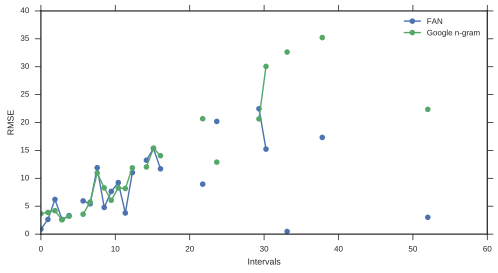

In [563]:
plt.figure(figsize=(8,4))
plt.plot(intervals, rmses1, label='FAN', marker='o')
plt.plot(intervals, rmses2, label='Google n-gram', marker='o')
plt.legend(loc='best')
plt.xlabel('Intervals')
plt.ylabel('RMSE')
plt.savefig('RMSEs.pdf')
plt.show()



In [564]:
len(intervals)

56

In [549]:
rmses1

array([         nan,   0.89782272,   2.63256199,   6.21949672,
         2.63254423,   3.32528047,          nan,   5.95380353,
         5.43170276,  11.90360858,   4.78334278,   7.65202251,
         9.23616145,   3.78570515,  11.03517638,          nan,
        13.24389405,  15.35270954,  11.70490576,          nan,
                nan,          nan,          nan,          nan,
         8.95593969,          nan,  20.1971447 ,          nan,
                nan,          nan,          nan,          nan,
        22.46828924,  15.23635035,          nan,          nan,
         0.46812012,          nan,          nan,          nan,
                nan,  17.33228678,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan])